In [1]:
# AIM OF THIS NOTE BOOK

## optional - download dataset
# https://cs.stanford.edu/~acoates/stl10/
# wget https://raw.githubusercontent.com/mttk/STL10/master/stl10_input.py
# python stl10_input.py

## generate random lines

## overlay lines to images

## train yolo with images with line

In [2]:
%load_ext autoreload
%autoreload 2

import traceback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from make_line import make_one_sample

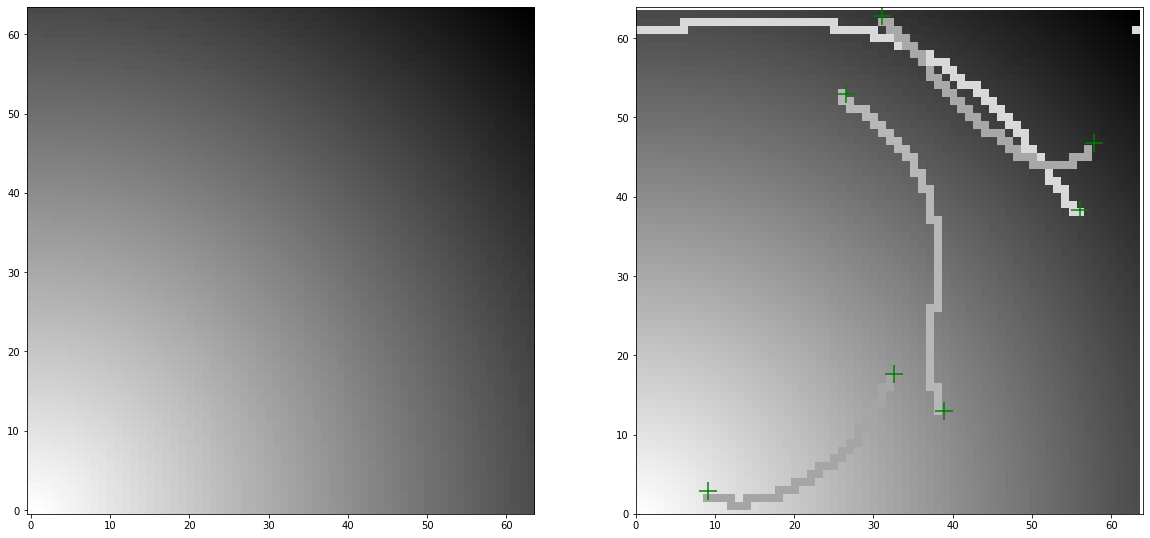

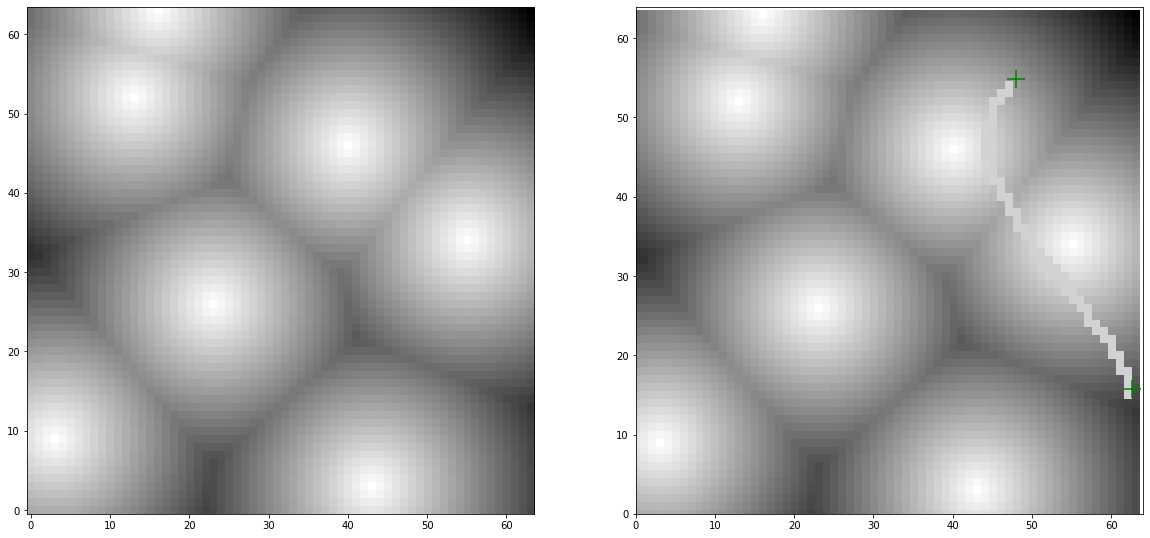

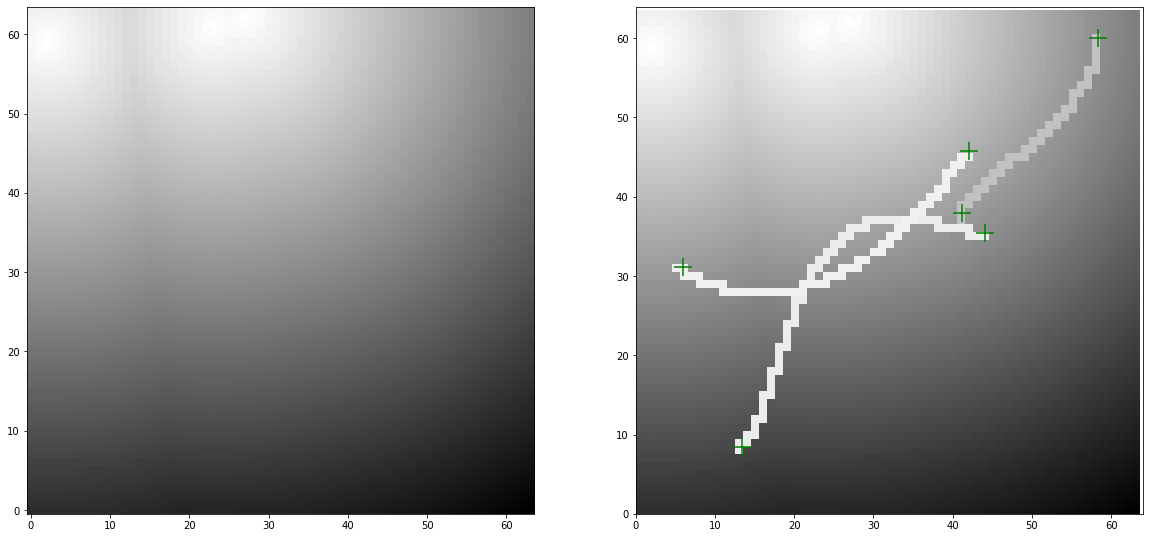

In [4]:
for n in range(3):
    try:
        terrain, container = make_one_sample(nx=64,ny=64,minlen=10,
            isplot=True,fignum=n,)
    except:
        pass
        traceback.print_exc()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


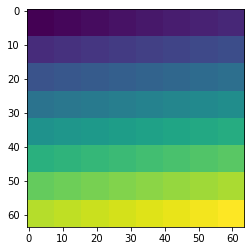

In [5]:
szx,szy,szz=64,64,64
smx,smy=8,8
grid = np.zeros((szx,szy)).astype(np.uint)


# assign grid id.
anchor_dict={}
for x in range(szx):
    for y in range(szy):
        px = x//smx
        py = y//smy
        code = py + smx*px
        if code not in anchor_dict.keys():
            anchor_dict[code]=(x,y)
        grid[x,y]=code
        
plt.imshow(grid)
print(np.unique(grid))

In [6]:
# x  (None,64,64)
# y0 (None,64,5)     - object,relstartx,relstarty,shapex,shapey
# y1 (None,64,64,64) - 64x(64,64) mask

In [7]:
def make_data(N=5):
    X0 = np.zeros((N,szx,szy)).astype(np.uint8)
    Y0 = np.zeros((N,szz,5)).astype(np.float)
    Y1 = np.zeros((N,szx,szy,szz)).astype(np.uint8)

    c=0
    for n in range(N*100):
        try:
            # make random line
            terrain, container = make_one_sample(nx=64,ny=64,minlen=10)
            # rescale input image
            terrain = (255*(terrain-np.max(terrain))/(np.max(terrain)-np.min(terrain))).astype(np.uint8)
            # for each line
            for row in container:
                # get mask and end points
                mask=row['mask'].astype(np.uint8)
                endpoints = np.array(row['endpoints']).astype(np.int)
                x0,y0=endpoints[0,:]
                x1,y1=endpoints[1,:]
                # ensure end points in line
                #assert(mask[x0,y0]==1 and mask[x1,y1]==1)

                istube=1
                # find min max point
                mask_indices = np.argwhere(mask>0)

                minx=np.min(mask_indices[:,0])
                miny=np.min(mask_indices[:,1])

                maxx=np.max(mask_indices[:,0])
                maxy=np.max(mask_indices[:,1])
                
                midx = (minx+maxx)/2.
                midy = (miny+maxy)/2.
                
                aindx=(midx).astype(np.int)
                aindy=(midy).astype(np.int)
                
                ind = grid[aindx,aindy]
                # get anchor in grid
                anchorx,anchory=anchor_dict[ind]
                
                # relative mid
                midx = midx-anchorx
                midy = midy-anchory
                
                # width
                widthx = maxx-minx
                widthy = maxy-miny
                
                # scale
                midx /= szx
                midy /= szy
                widthx /= szx
                widthy /= szy
                
                yolo = np.array([midx,midy,widthx,widthy,istube])
                #print(yolo)
                
                Y0[c,ind,:]=yolo
                Y1[c,ind,:,:]=mask
            
            X0[c,:,:]=terrain
        
        except:
            #traceback.print_exc()
            if c >= N:
                break
            X0[c,...]=0
            Y0[c,...]=0
            Y1[c,...]=0
        
        if c>=N:
            break
        
        c+=1
        
    return X0,Y0,Y1


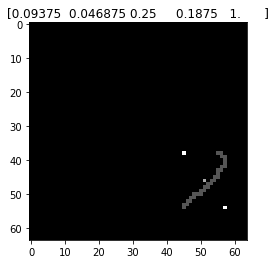

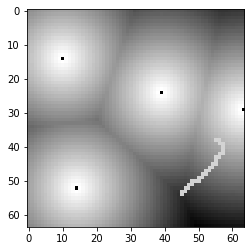

In [8]:
X0,Y0,Y1 = make_data(N=5)
c=0
ind = 0
for aind in range(smx*smy):    
    y0 = Y0[ind,aind,:]
    midx,midy,widthx,widthy,istube = y0
    if istube == 0:
        continue
    
    tmp = Y1[ind,aind,:,:]
    
    ax,ay = anchor_dict[aind]
    
    midx = ax+midx*szx
    midy = ay+midy*szy
    
    whx = widthx*szx/2.
    why = widthy*szy/2.
    
    startx = midx-whx
    starty = midy-why
    
    endx = midx+whx
    endy = midy+why
    
    midx = midx.astype(np.int)
    midy = midy.astype(np.int)
    startx = startx.astype(np.int)
    starty = starty.astype(np.int)
    endx = endx.astype(np.int)
    endy = endy.astype(np.int)
    
    tmp[midx,midy]=2
    tmp[startx,starty]=3
    tmp[endx,endy]=3

    plt.figure(c)    
    plt.title('{}'.format(y0))
    plt.imshow(tmp,cmap='gray',origin='upper')    
    c+=1
    
plt.figure(c)
plt.imshow(X0[ind,],cmap='gray')

In [9]:
x_train, y_train0, y_train1 = make_data(N=1024)
x_train = np.expand_dims(x_train,axis=-1)
x_val, y_val0, y_val1 = make_data(N=100)
x_val = np.expand_dims(x_val,axis=-1)
x_testA, y_test0A, y_test1A = make_data(N=5)
x_testA = np.expand_dims(x_testA,axis=-1)

In [10]:
y_train0.shape

(1024, 64, 5)

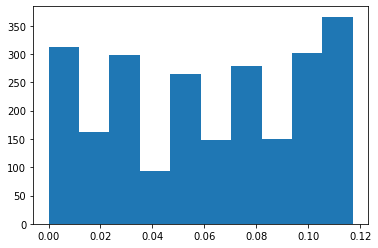

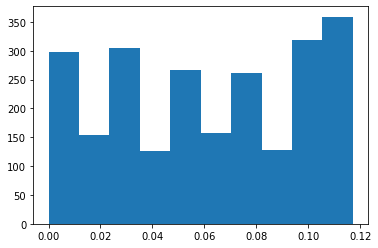

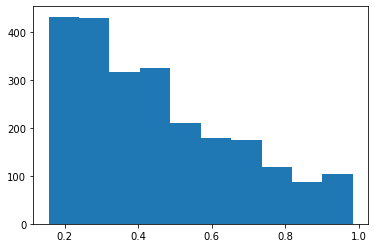

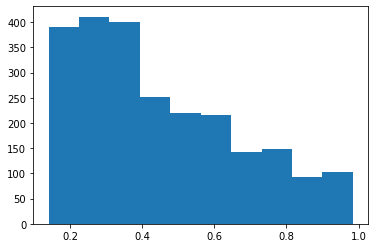

In [11]:
for n,x in enumerate([0,1,2,3]):
    plt.figure(n)
    # fetch out those with lines
    obj = y_train0[:,:,-1].ravel()
    val = y_train0[:,:,x].ravel()
    _ = plt.hist(val[obj==1])

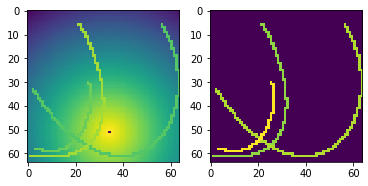

In [12]:
ind = -2
plt.subplot(121)
plt.imshow(x_train[ind,:].squeeze())
region = np.argwhere(y_train0[ind,:,-1]==1)
tmp = np.zeros((szx,szy))
for r in region.squeeze():
    tmp[y_train1[ind,r,:,:].squeeze()==1]=r+1
plt.subplot(122)
plt.imshow(tmp)

In [22]:
SEED = 0
import os
import random as rn
import numpy as np
from tensorflow import set_random_seed

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
set_random_seed(SEED)
rn.seed(SEED)

In [14]:


import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)

from keras.models import Sequential, load_model
from keras import optimizers as opt
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Reshape, Conv2DTranspose
from keras.callbacks import LearningRateScheduler,EarlyStopping

from keras.models import Model
from keras.layers import Permute, Reshape, Lambda, add, Input, Concatenate
from keras.layers import Conv2D, BatchNormalization, LeakyReLU
from keras import regularizers, initializers
import tensorflow as tf
from keras import backend as K


Using TensorFlow backend.


In [44]:
SEED = 0
import os
import random as rn
import numpy as np
from tensorflow import set_random_seed

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
set_random_seed(SEED)
rn.seed(SEED)


# simple yolo
#   https://gist.github.com/msrks/ce613e91a98868d4a059c6c5c5e30ba3
# vanillay conv cannot prediction coord
#   https://eng.uber.com/coordconv/
# alternative archetectures.
#   https://towardsdatascience.com/r-cnn-fast-r-cnn-faster-r-cnn-yolo-object-detection-algorithms-36d53571365e
#   https://github.com/jianing-sun/Mask-YOLO
# actual yolos
#   https://github.com/ksanjeevan/dourflow/blob/master/net/netarch.py
#   https://github.com/guigzzz/Keras-Yolo-v2


epsilon = 1E-8
def compute_obj_loss(y_true,y_pred):
    return tf.keras.backend.binary_crossentropy(y_true[...,-1], y_pred[...,-1])

def compute_coord_loss(y_true,y_pred):
    loss_px = tf.squared_difference(y_true[...,0], y_pred[...,0])
    loss_py = tf.squared_difference(y_true[...,1], y_pred[...,1])
    loss_wx = tf.squared_difference(y_true[...,2], y_pred[...,2])
    loss_wy = tf.squared_difference(y_true[...,3], y_pred[...,3])
    loss_pos = tf.multiply(y_true[...,-1],tf.add(loss_px,loss_py))
    loss_width = tf.multiply(y_true[...,-1],tf.add(loss_wx,loss_wy))
    return loss_pos+loss_width

def compute_iou_loss(y_true,y_pred):
    # ref. https://github.com/ksanjeevan/dourflow/blob/master/net/netloss.py
    def process_boxes(A):
        # ALign x-w, y-h
        A_xy = A[..., 0:2]
        A_wh = A[..., 2:4]
        
        A_wh_half = A_wh / 2.
        # Get x_min, y_min
        A_mins = A_xy - A_wh_half
        # Get x_max, y_max
        A_maxes = A_xy + A_wh_half
        
        return A_mins, A_maxes, A_wh
    
    # Process two sets
    A2_mins, A2_maxes, A2_wh = process_boxes(y_pred)
    A1_mins, A1_maxes, A1_wh = process_boxes(y_true)
    
    # Intersection as min(Upper1, Upper2) - max(Lower1, Lower2)
    intersect_mins  = K.maximum(A2_mins,  A1_mins)
    intersect_maxes = K.minimum(A2_maxes, A1_maxes)
    
    # Getting the intersections in the xy (aka the width, height intersection)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)

    # Multiply to get intersecting area
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    # Values for the single sets
    true_areas = A1_wh[..., 0] * A1_wh[..., 1]
    pred_areas = A2_wh[..., 0] * A2_wh[..., 1]
    
    # Compute union for the IoU
    union_areas = pred_areas + true_areas - intersect_areas
    
    # probably not necssary...
    iou_loss = tf.multiply(y_true[...,-1], intersect_areas / (union_areas+epsilon) )
    
    return iou_loss


def vec_loss(y_true, y_pred):
    
    lambda_obj = 1.0
    lambda_coord = 1.0
    lambda_iou = 1.0
    
    obj_loss = compute_obj_loss(y_true, y_pred)
    obj_loss = tf.multiply(lambda_obj,obj_loss)
    
    coord_loss = compute_coord_loss(y_true, y_pred)
    coord_loss = tf.multiply(lambda_coord,coord_loss)
    
    iou_loss = compute_iou_loss(y_true, y_pred)
    iou_loss = tf.multiply(lambda_iou,iou_loss)
    
    total_loss = tf.add(tf.add(obj_loss,coord_loss),iou_loss)
    
    return tf.reduce_mean(total_loss)


def conv_batch_lrelu(input_tensor, numfilter, dim, strides=2):
    # https://github.com/guigzzz/Keras-Yolo-v2/blob/f61286371cdc2d470e0811234f552c70bbd5caba/yolo_layer_utils.py#L18
    input_tensor = Conv2D(numfilter, (dim, dim), strides=strides, padding='same',
                        kernel_regularizer=regularizers.l2(0.0005),
                        kernel_initializer=initializers.TruncatedNormal(stddev=0.1),
                        use_bias=False
                    )(input_tensor)
    input_tensor = BatchNormalization()(input_tensor)
    return LeakyReLU(alpha=0.1)(input_tensor)

def convt_batch_lrelu(input_tensor, numfilter, dim, strides=2):
    input_tensor = Conv2DTranspose(numfilter, (dim, dim), strides=strides, padding='same',
                        kernel_regularizer=regularizers.l2(0.0005),
                        kernel_initializer=initializers.TruncatedNormal(stddev=0.1),
                        use_bias=False
                    )(input_tensor)
    input_tensor = BatchNormalization()(input_tensor)
    return LeakyReLU(alpha=0.1)(input_tensor)

MASK = 'MASK'
VECTOR = 'VECTOR'

inputs = Input(shape=(szx,szy,1))

# down sample
xd = conv_batch_lrelu(inputs, 32, 3)
xd = conv_batch_lrelu(xd, 64, 3)
xd = conv_batch_lrelu(xd, 128, 3)
xd = conv_batch_lrelu(xd, 256, 3)

# bottle neck
x=Flatten()(xd)
x=Dense(1024)(x) # # filter size ratio between conv and dense needs to be tuned!
x=Activation('relu')(x)
x=Dropout(0.5)(x)
x=Dense(512)(x)
x=Activation('relu')(x)
x=Dropout(0.5)(x)
x=Dense(smx*smy*5)(x)
x=Reshape((smx*smy,5))(x)

# output split - split output to have varying activations for pos,width, and obj
# output: pos and width
x_pos_width = Lambda(lambda x: x[..., 0:4])(x)
x_pos_width=Activation('linear')(x_pos_width)
x_pos_width=Lambda(lambda x: K.clip(x,0.,1.))(x_pos_width)

# output: sigmoid
x_obj = Lambda(lambda x: K.expand_dims(x[..., -1],axis=-1))(x)
x_obj=Activation('sigmoid')(x_obj)

# merge outputs
vecs = Concatenate(axis=-1,name=VECTOR)([x_pos_width,x_obj])
model = Model(inputs=inputs, outputs=vecs)
model.summary()
print(x_train.shape,y_train0.shape,y_train1.shape)


# very nice ref. https://github.com/ksanjeevan/dourflow/blob/master/yolov2.py
# opt.Adam, opt.RMSprop

batch_size = 8
epochs=100
lr=1E-3
decay=1E-3
beta_1=0.9
beta_2=0.999



early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=20,
                              verbose=0,
                              mode='min')
callbacks = [early_stopping]

optimizer = opt.Adam(lr=lr,beta_1=beta_1, beta_2=beta_2, decay=decay)
model.compile(loss=vec_loss, optimizer=optimizer)
history = model.fit(x_train, y_train0,
                    batch_size=batch_size, epochs=epochs,
                    verbose=1, 
                    validation_data=(x_val, y_val0),
                    callbacks=callbacks)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 32, 32, 32)   288         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 32, 32, 32)   128         conv2d_17[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_17 (LeakyReLU)      (None, 32, 32, 32)   0           batch_normalization_17[0][0]     
__________________________________________________________________________________________________
conv2d_18 

ResourceExhaustedError: OOM when allocating tensor with shape[4096,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_5/Adam/mul_63}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss_5/add_3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
#for k,v in history.history.items():
#    history.history[k]=v/v[0]   
df = pd.DataFrame(history.history)
df.plot()

In [ ]:
history.history.keys()

In [42]:
#x_test, y_test0, y_test1 = x_testA, y_test0A, y_test1A
#x_test, y_test0, y_test1 = x_train, y_train0, y_train1
#x_test, y_test0, y_test1 = x_val, y_val0, y_val1
pred = model.predict(x_test)
pred = [pred]

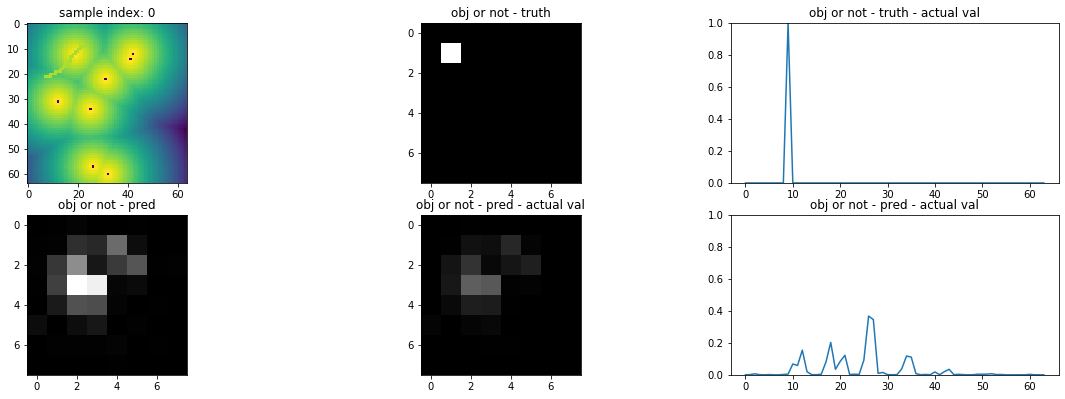

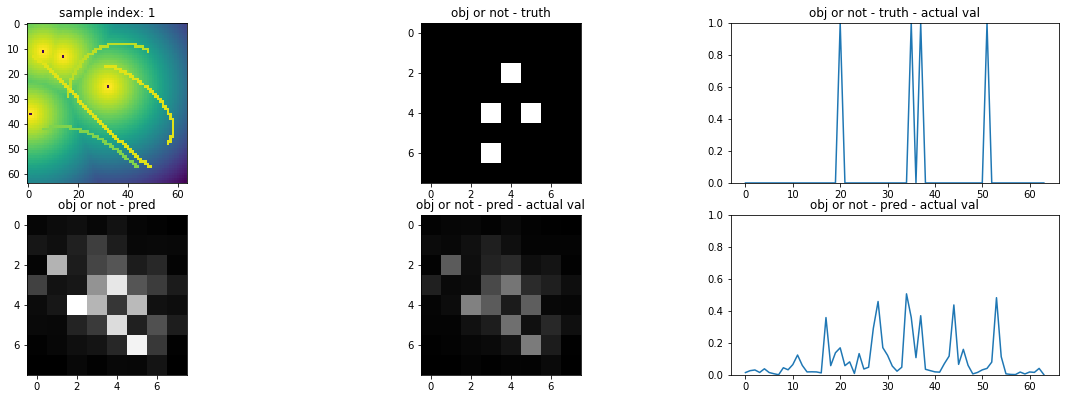

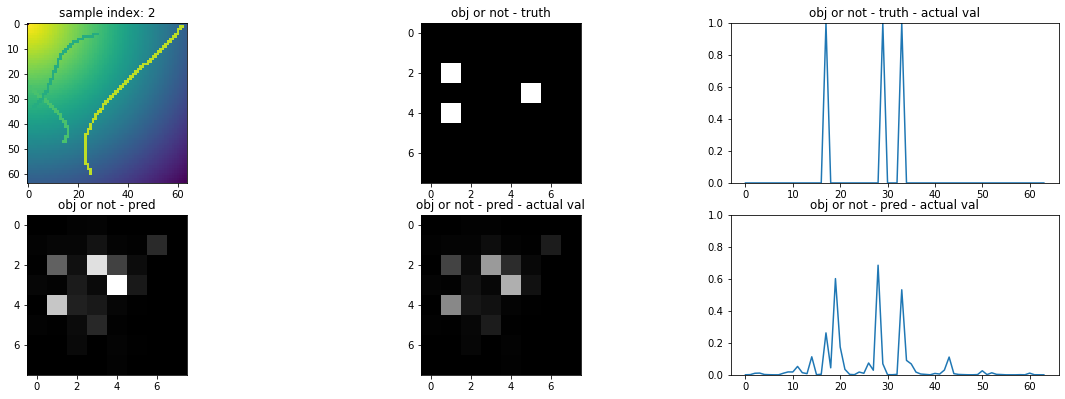

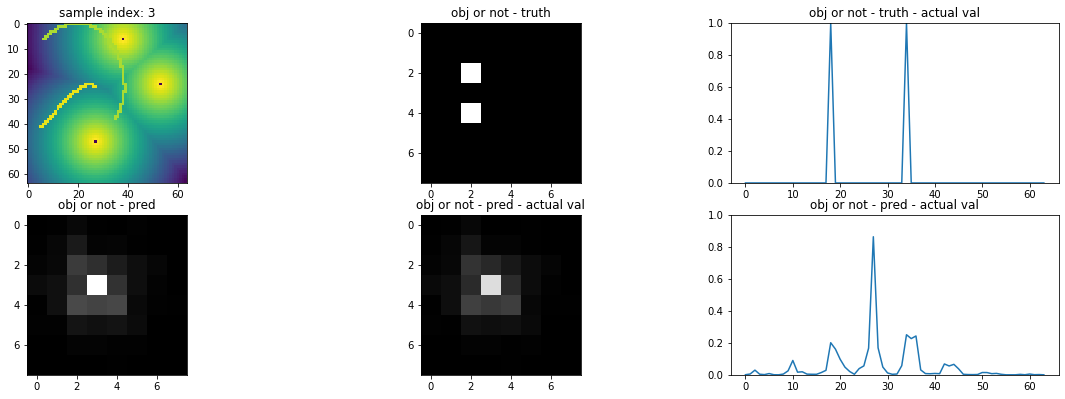

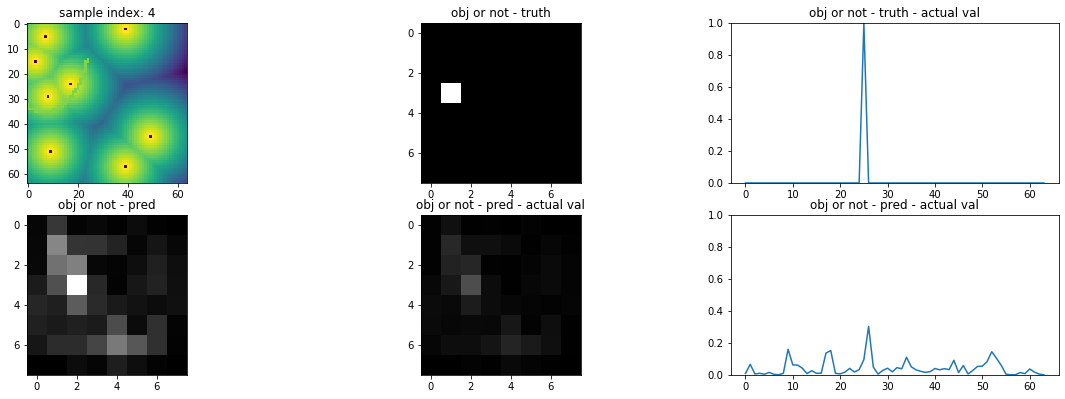

In [43]:
obj_ind = -1

#for ind in range(pred.shape[0]):
for ind in range(5):
    
    plt.figure(ind,figsize=(20,10))
    
    # GROUND TRUTH
    plt.subplot(331)
    plt.title('sample index: {}'.format(ind))
    plt.imshow(x_test[ind,:].squeeze())

    region = np.argwhere(y_test0[ind,:,obj_ind]==1).ravel()
    obj_real = np.zeros((szx,szy))
    for r in region:
        obj_real[grid==r]=1
    obj_real = np.reshape(y_test0[ind,:,obj_ind],(smx,smy))
    
    plt.subplot(332)
    plt.title('obj or not - truth'.format())
    plt.imshow(obj_real,cmap='gray')
    obj = np.reshape(pred[0][ind,:,obj_ind],(smx,smy))

    ax = plt.subplot(333)
    plt.title('obj or not - truth - actual val'.format())
    plt.plot(y_test0[ind,:,obj_ind])
    ax.set_ylim(0,1)
    
    # PREDICTED
    plt.subplot(334)
    plt.title('obj or not - pred'.format())
    plt.imshow(obj,cmap='gray')
    plt.subplot(335)
    plt.title('obj or not - pred - actual val'.format())
    plt.imshow(obj,vmin=0,vmax=1,cmap='gray')
    
    ax = plt.subplot(336)
    plt.title('obj or not - pred - actual val'.format())
    plt.plot(pred[0][ind,:,obj_ind])
    ax.set_ylim(0,1)
    
    if len(pred)>1:
        plt.subplot(337)
        plt.title('mask - pred'.format())
        argmax = np.argmax(pred[0][ind,:,obj_ind])
        plt.title('argmax {}'.format(argmax))
        plt.imshow(pred[1][ind,argmax,:,:].squeeze(),cmap='gray')